In [1]:
!pip install --upgrade plotly

     |████████████████████████████████| 13.2MB 27.5MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [2]:
import datetime as dt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web

In [3]:
# Get the stock quote
crypto_currency = 'EGLD'  # BTC
against_currency = 'EUR'
data_source ='yahoo'
period = 100

start = dt.datetime(2012, 1, 1)
end = dt.datetime.now()

ticket = f'{crypto_currency}-{against_currency}'

df = web.DataReader(ticket, data_source=data_source, start=start, end=end)

df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-09-03,17.249926,14.310493,14.526996,14.920788,14802849.0,14.920788
2020-09-21,7.712698,7.215655,7.522677,7.450191,4526677.0,7.450191
2020-09-22,8.099385,7.132053,7.449963,7.561184,8002122.0,7.561184
2020-09-23,7.905009,7.501416,7.565778,7.879223,4921239.0,7.879223
2020-09-24,8.687509,7.874770,7.913646,8.605440,6296125.0,8.605440


In [4]:
df.reset_index(inplace = True)
df.set_index(["Date"])
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2020-09-03,17.249926,14.310493,14.526996,14.920788,14802849.0,14.920788
1,2020-09-21,7.712698,7.215655,7.522677,7.450191,4526677.0,7.450191
2,2020-09-22,8.099385,7.132053,7.449963,7.561184,8002122.0,7.561184
3,2020-09-23,7.905009,7.501416,7.565778,7.879223,4921239.0,7.879223
4,2020-09-24,8.687509,7.874770,7.913646,8.605440,6296125.0,8.605440


In [5]:
sma = df['Close'].rolling(window=period).mean()  # Simple moving average (SMA)
std = df['Close'].rolling(window=period).std()  # Standard deviation
df['Upper'] = sma + (std *2)  # Bollinger band
df['Lower'] = sma - (std *2)  # Bollinger band

df['Short'] = df.Close.ewm(span=20, adjust=False).mean()  # Exponential moving average 20 days
df['Long'] = df.Close.ewm(span=50, adjust=False).mean()  # Exponential moving average 50 days

df['20MA'] = df['Close'].rolling(window=20).mean()  # 20 moving average (20MA)
df['50MA'] = df['Close'].rolling(window=50).mean()  # 50 moving average (50MA)

shortema = df.Close.ewm(span=12, adjust=False).mean()  # Exponential moving average 12 days
longema = df.Close.ewm(span=26, adjust=False).mean()  # Exponential moving average 26 days
df['MACD'] = shortema - longema  # MACD
df['Signal'] = df.MACD.ewm(span=9, adjust=False).mean()  # Exponential moving average 9 days

df['PClose'] = df['Adj Close'].shift()  # previous Close
df['High-Low'] = df['High'] - df['Low']  # Condition 1: High - Low
df['High-PClose'] = abs(df['High'] - df['PClose'])  # Condition 2: High - Previous Close
df['Low-PClose'] = abs(df['Low'] - df['PClose'])  # Condition 3: Low - Previous Close
df['TrueRange'] = df[['High-Low', 'High-PClose', 'Low-PClose']].max(axis=1) # True Range
df['ATR'] = df.TrueRange.rolling(window=14).mean() / df['Adj Close'] *100  # Average True Range 14 days %

df

,Date,High,Low,Open,Close,Volume,Adj Close,Upper,Lower,Short,Long,20MA,50MA,MACD,Signal,PClose,High-Low,High-PClose,Low-PClose,TrueRange,ATR
0,2020-09-03,17.249926,14.310493,14.526996,14.920788,14802849.0,14.920788,NaN,NaN,14.920788,14.920788,NaN,NaN,0.000000,0.000000,NaN,2.939433,NaN,NaN,2.939433,NaN
1,2020-09-21,7.712698,7.215655,7.522677,7.450191,4526677.0,7.450191,NaN,NaN,14.209302,14.627823,NaN,NaN,-0.595945,-0.119189,14.920788,0.497043,7.208090,7.705132,7.705132,NaN
2,2020-09-22,8.099385,7.132053,7.449963,7.561184,8002122.0,7.561184,NaN,NaN,13.576148,14.350700,NaN,NaN,-1.047208,-0.304793,7.450191,0.967332,0.649194,0.318139,0.967332,NaN
3,2020-09-23,7.905009,7.501416,7.565778,7.879223,4921239.0,7.879223,NaN,NaN,13.033584,14.096917,NaN,NaN,-1.363457,-0.516526,7.561184,0.403593,0.343825,0.059768,0.403593,NaN
4,2020-09-24,8.687509,7.874770,7.913646,8.605440,6296125.0,8.605440,NaN,NaN,12.611856,13.881565,NaN,NaN,-1.537761,-0.720773,7.879223,0.812738,0.808286,0.004453,0.812738,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2021-05-30,85.428810,73.821785,76.229012,84.982803,45695053.0,84.982803,184.404570,70.444239,97.932824,116.745521,98.649080,132.075305,-15.622555,-15.685590,76.293114,11.607025,9.135696,2.471329,11.607025,22.188424
250,2021-05-31,85.973892,80.799637,84.860687,83.019577,47520722.0,83.019577,184.720310,69.471103,96.512514,115.422935,95.862382,129.949203,-14.892439,-15.526960,84.982803,5.174255,0.991089,4.183167,5.174255,22.397937
251,2021-06-01,89.161293,80.998741,83.075745,84.765160,41602109.0,84.765160,184.967729,68.833722,95.393719,114.220669,93.419913,128.091122,-14.011448,-15.223857,83.019577,8.162552,6.141716,2.020836,8.162552,17.582523
252,2021-06-02,91.128883,83.580330,84.790039,88.454704,40265163.0,88.454704,184.997805,68.766246,94.732860,113.210239,91.087323,126.077478,-12.867215,-14.752529,84.765160,7.548553,6.363724,1.184830,7.548553,15.267757


In [6]:
df = df.loc[df.shape[0]-period:]
df.reset_index(inplace = True)
df.head()

,index,Date,High,Low,Open,Close,Volume,Adj Close,Upper,Lower,Short,Long,20MA,50MA,MACD,Signal,PClose,High-Low,High-PClose,Low-PClose,TrueRange,ATR
0,154,2021-02-25,105.088066,92.988770,95.948364,93.152092,122798581.0,93.152092,125.841853,-39.854245,103.710731,80.002408,118.988659,71.140704,7.271151,14.160459,95.841858,12.099297,9.246208,2.853088,12.099297,23.130044
1,155,2021-02-26,105.763008,86.040276,93.330391,102.737434,206833707.0,102.737434,127.324230,-39.408518,103.618036,80.893977,120.134358,72.590302,6.446248,12.617617,93.152092,19.722733,12.610916,7.111816,19.722733,20.948800
2,156,2021-02-27,125.440765,101.587120,102.871552,112.169563,287286959.0,112.169563,129.137075,-39.105953,104.432468,82.120471,119.904809,74.222020,6.478914,11.389876,102.737434,23.853645,22.703331,1.150314,23.853645,19.901649
3,157,2021-02-28,112.948769,100.109627,112.316910,107.750038,143574658.0,107.750038,130.711271,-38.653572,104.748427,83.125552,118.374213,75.771352,6.078120,10.327525,112.169563,12.839142,0.779205,12.059937,12.839142,20.660322
4,158,2021-03-01,119.107368,107.463173,107.886230,114.775276,128223590.0,114.775276,132.521389,-38.306356,105.703365,84.366718,116.023827,77.472031,6.255258,9.513072,107.750038,11.644196,11.357330,0.286865,11.644196,16.857882


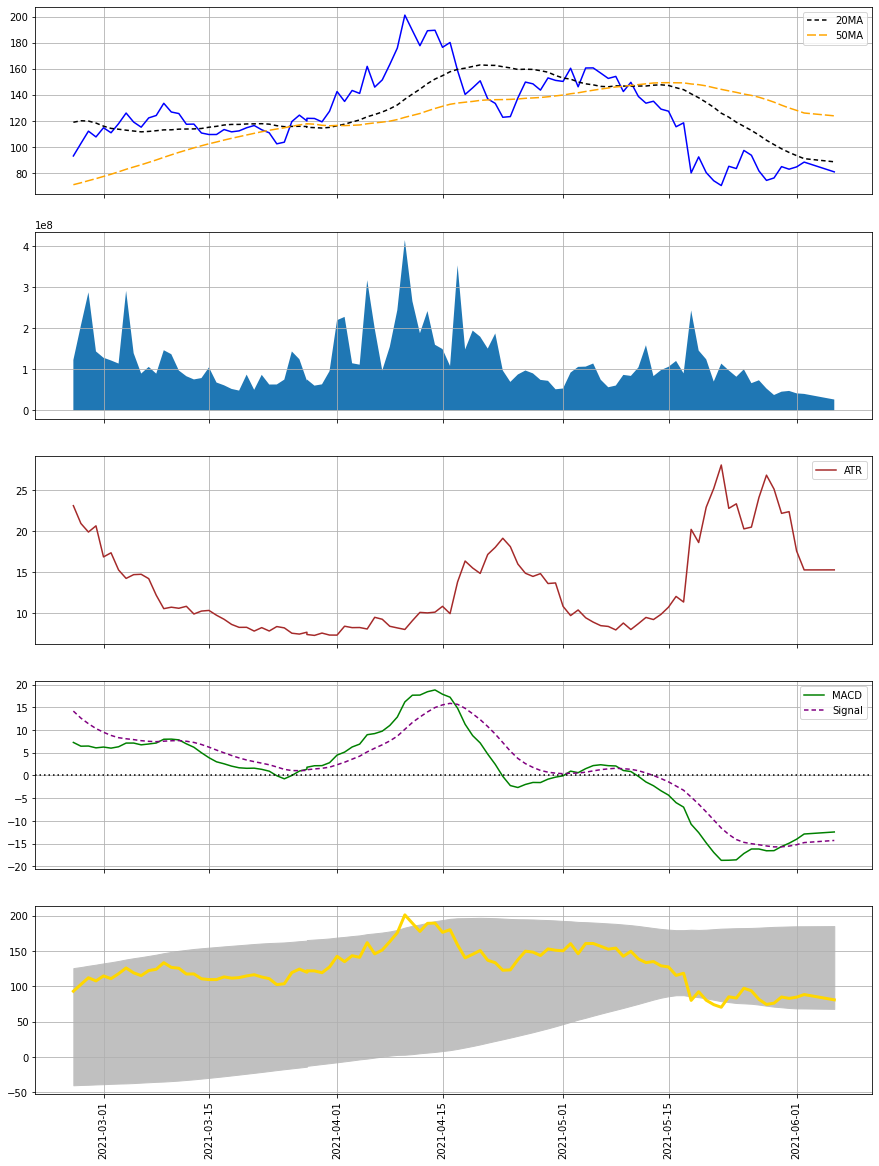

In [7]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20))

# Closed Price + 20MA + 50MA
axs[0].plot(df['Date'], df['Close'], color='blue')
axs[0].plot(df['Date'], df['20MA'], label='20MA', color='black', dashes=[3, 2])
axs[0].plot(df['Date'], df['50MA'], label='50MA', color='orange', dashes=[6, 2])
axs[0].set(xticklabels=[])
axs[0].grid(True)
axs[0].legend(loc="upper right")

# Volume
axs[1].fill_between(df['Date'], df['Volume'])
axs[1].set(xticklabels=[])
axs[1].grid(True)

# ATR
axs[2].plot(df['Date'], df['ATR'], label='ATR', color='brown')
axs[2].set(xticklabels=[])
axs[2].grid(True)
axs[2].legend(loc="upper right")

# MACD
axs[3].plot(df['Date'], df['MACD'], label='MACD', color='green')
axs[3].plot(df['Date'], df['Signal'], label='Signal', color='purple', dashes=[3, 2])
axs[3].axhline(y = 0, color = 'black', dashes=[1, 2])
axs[3].set(xticklabels=[])
axs[3].grid(True)
axs[3].legend(loc="upper right")

# Bolinger
axs[4].fill_between(df['Date'], df['Upper'], df['Lower'], color='silver')
axs[4].plot(df['Date'], df['Close'], color='gold', lw=3, label='Close Price')
axs[4].tick_params(axis='x', rotation=90)
axs[4].grid(True)

# fig.tight_layout()
plt.show()

In [8]:
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.options.plotting.backend = "plotly"

In [9]:
Closed_Price = go.Scatter(
    x=df['Date'],
    y=df['Close'],
    name='Close',
    line_color='blue',
)
MA20 = go.Scatter(
    x=df['Date'],
    y=df['20MA'],
    name='20MA',
    line_color='black',
)
MA50 = go.Scatter(
    x=df['Date'],
    y=df['50MA'],
    name='50MA',
    line_color='orange',
)
Upper = go.Scatter(
    x=df['Date'],
    y=df['Upper'],
    name='Upper',
    line_color='silver',
)
Lower = go.Scatter(
    x=df['Date'],
    y=df['Lower'],
    name='Lower',
    fill='tonexty', # fill area between
    mode='lines',
    line_color='silver',
)
data = [Closed_Price, MA20, MA50, Upper, Lower]
layout = go.Layout(yaxis=dict())
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title='Closed Price',
    yaxis_title='Price',
    xaxis_title='Dates',
    legend_title='Indicator',
    )
fig.show()

In [25]:
Volume = go.Scatter(
    x=df['Date'],
    y=df['Volume'],
    name='Volume',
    line_color='blue',
    fill='tonexty', # fill area between
    mode='lines',
)
layout = go.Layout(yaxis=dict())
fig = go.Figure(data=Volume, layout=layout)
#fig.add_hline(y=0, line_color="green")
fig.update_layout(
    title='Volume',
    yaxis_title='Operations',
    xaxis_title='Dates',
    legend_title='Indicator',
    )
fig.show()

In [22]:
fig = df['ATR'].plot()
fig.update_layout(
    title='ATR',
    yaxis_title='ATR %',
    xaxis_title='Dates',
    legend_title='Indicator',
    )
fig.show()

In [24]:
MACD = go.Scatter(
    x=df['Date'],
    y=df['MACD'],
    name='MACD',
    line_color='green',
    fill='tonexty', # fill area between
    mode='lines',
)
Signal = go.Scatter(
    x=df['Date'],
    y=df['Signal'],
    name='Signal',
    line_color='purple',
    line_dash='dot',
)
data = [MACD, Signal]
layout = go.Layout(yaxis=dict())
fig = go.Figure(data=data, layout=layout)
fig.add_hline(y=0, line_color="green")
fig.update_layout(
    title='MACD',
    yaxis_title='MACD',
    xaxis_title='Dates',
    legend_title='Indicator',
    )
fig.show()